# Finding Crypto Trade Outliers

### Library Imports

In [73]:
import pandas as pd
import pyarrow.dataset as ds
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
ROLLING_WINDOW = 4
SIGMA = 5

### Importing Price Data

In [75]:
file_name = "/Users/firstsingularity/DataspellProjects/sorrentum_ind/bulk.airflow.downloaded_1min.parquet.ohlcv.futures.v7.ccxt.binance.v1_0_0"
schema = None
partitioning = ds.partitioning(schema, flavor="hive")
dataset = pq.ParquetDataset(
    # Replace URI with path.
    file_name,
    #filesystem=filesystem,
    #filters=filters,
    partitioning=partitioning,
    use_legacy_dataset=False,
)
# To read also the index we need to use `read_pandas()`, instead of
# `read_table()`.
# See https://arrow.apache.org/docs/python/parquet.html#reading-and-writing-single-files.
columns = None
table = dataset.read_pandas(columns=columns)
df = table.to_pandas()

display(df.head())

,timestamp,open,high,low,close,volume,exchange_id,knowledge_timestamp,currency_pair,year,month
timestamp,,,,,,,,,,,
2022-10-01 00:00:00+00:00,1664582400000,5.406,5.406,5.401,5.403,20601.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10
2022-10-01 00:01:00+00:00,1664582460000,5.403,5.404,5.401,5.403,7417.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10
2022-10-01 00:02:00+00:00,1664582520000,5.403,5.407,5.403,5.407,4555.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10
2022-10-01 00:03:00+00:00,1664582580000,5.406,5.408,5.404,5.405,11194.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10
2022-10-01 00:04:00+00:00,1664582640000,5.404,5.406,5.404,5.405,1942.0,binance,2022-10-02 00:17:30.835182+00:00,APE_USDT,2022,10


### Calculating Close-Close Price Differences

In [76]:
df = df[['currency_pair', 'close']]
df.index = df.index.tz_convert('America/New_York')
df = df.set_index(['currency_pair'], append=True)
df = df.swaplevel(0, 1)
df = df.sort_index()
df.groupby([pd.Grouper(level='currency_pair'),
            pd.Grouper(level='timestamp', freq='T')]
           ).mean()
df.head()

close
currency_pair timestamp                       
APE_USDT      2022-03-17 11:00:00-04:00  8.775
              2022-03-17 11:01:00-04:00  8.811
              2022-03-17 11:02:00-04:00  8.913
              2022-03-17 11:03:00-04:00  8.913
              2022-03-17 11:04:00-04:00  8.952

1. Drop unused columns
2. Convert DataFrame to MultiIndex
3. Resample 'timestamp' to minutes

In [77]:
df['pct_change'] = df.groupby(level='currency_pair')['close'].pct_change()
df['norm_pct_change'] = (df.groupby(level='currency_pair')['pct_change'].rolling(ROLLING_WINDOW).mean() / df.groupby(level='currency_pair')['pct_change'].rolling(ROLLING_WINDOW).std()).droplevel(0)
df.head()

close  pct_change  norm_pct_change
currency_pair timestamp                                                    
APE_USDT      2022-03-17 11:00:00-04:00  8.775         NaN              NaN
              2022-03-17 11:01:00-04:00  8.811    0.004103              NaN
              2022-03-17 11:02:00-04:00  8.913    0.011576              NaN
              2022-03-17 11:03:00-04:00  8.913    0.000000              NaN
              2022-03-17 11:04:00-04:00  8.952    0.004376         1.042072

4. Calculate percent changes in closing prices
5. Compute a rolling norm on the percent changes

### Normalized Percent Change Plots

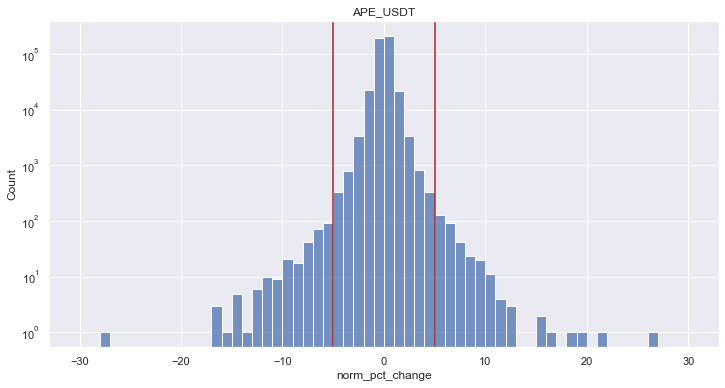

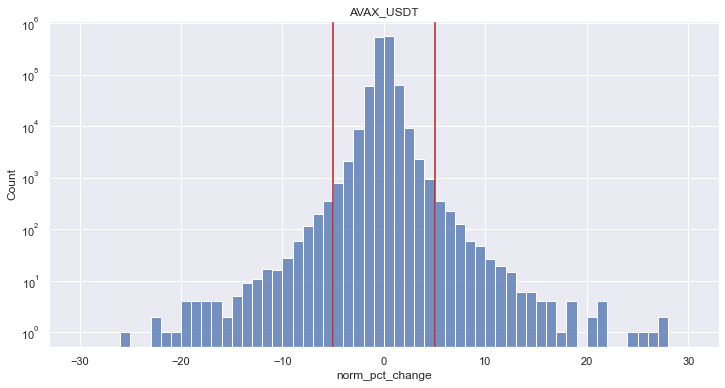

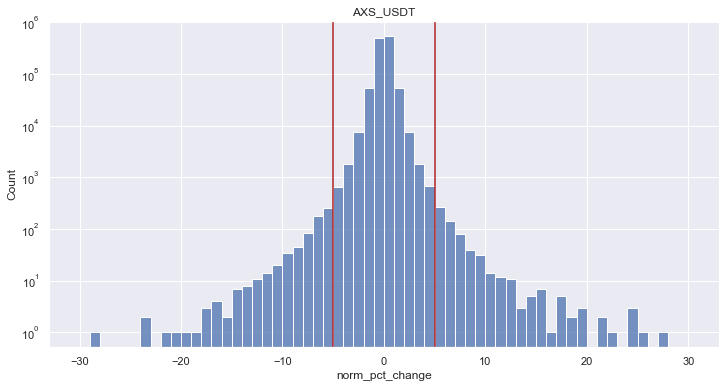

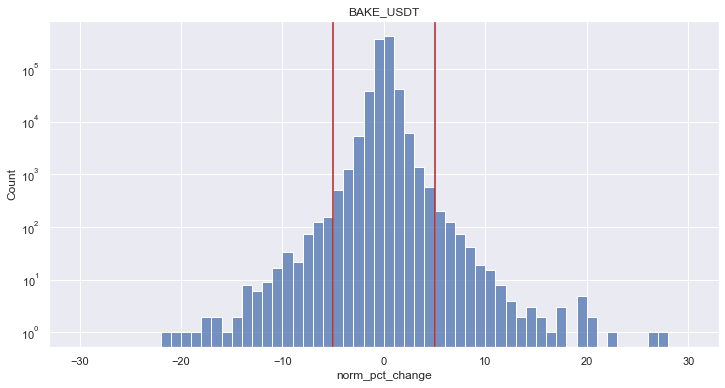

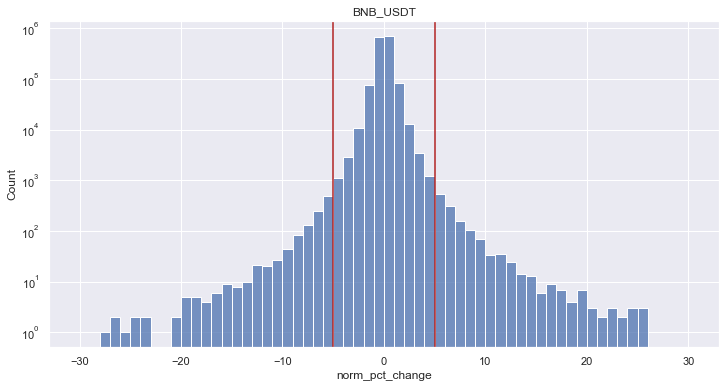

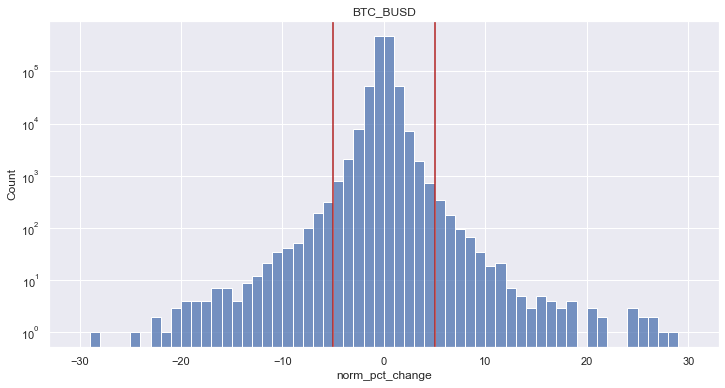

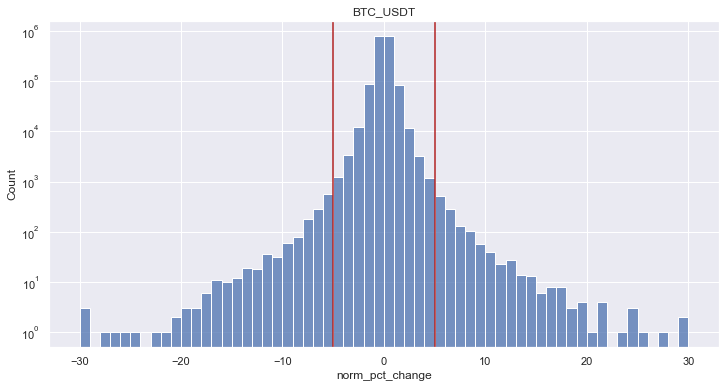

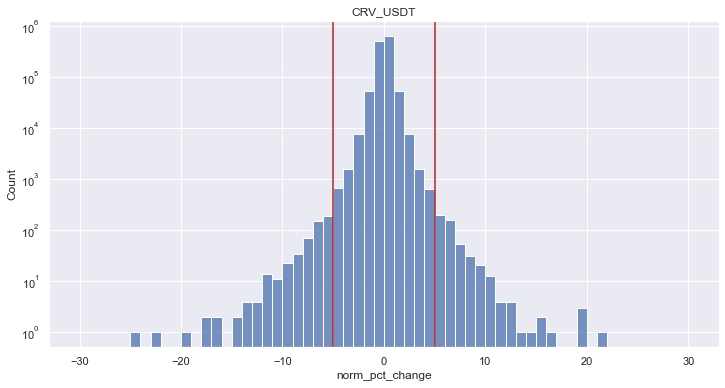

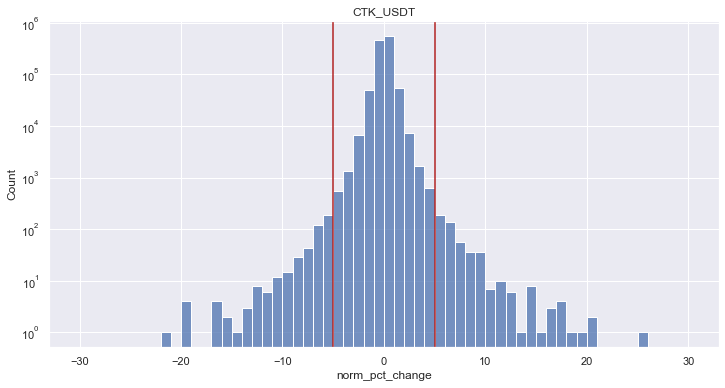

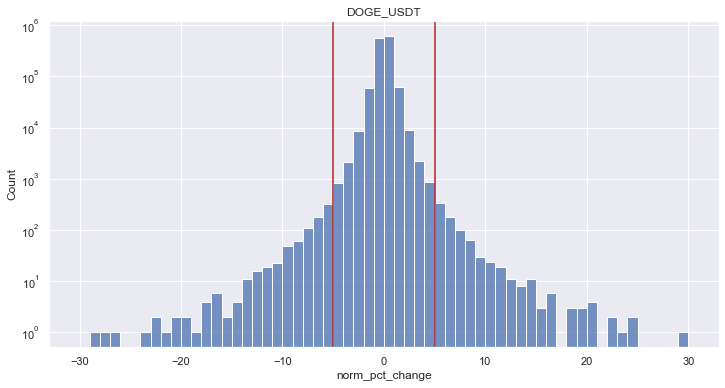

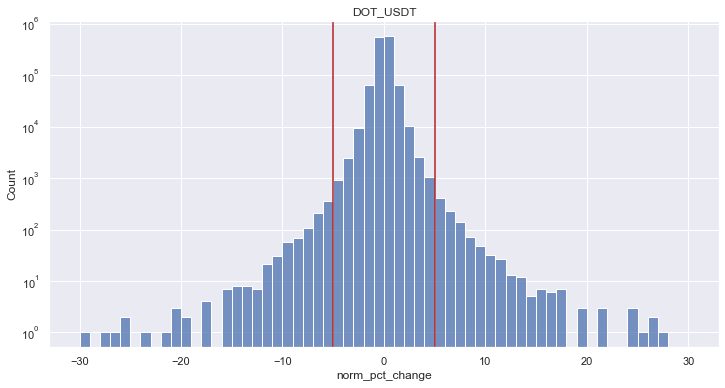

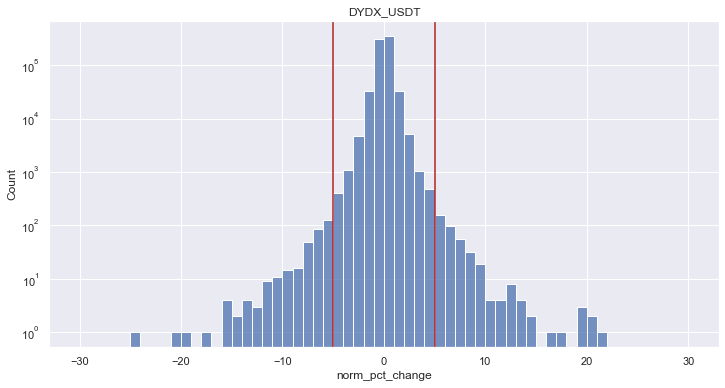

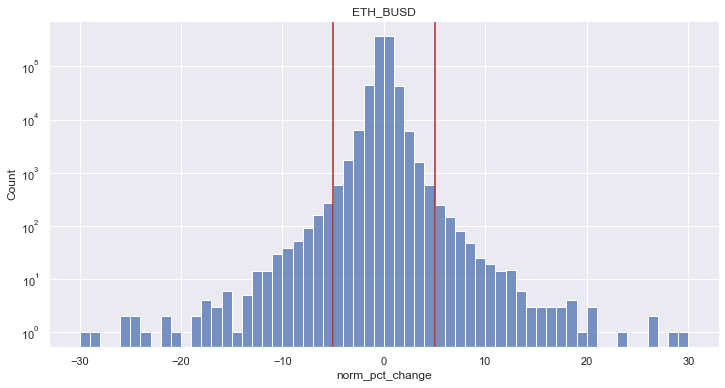

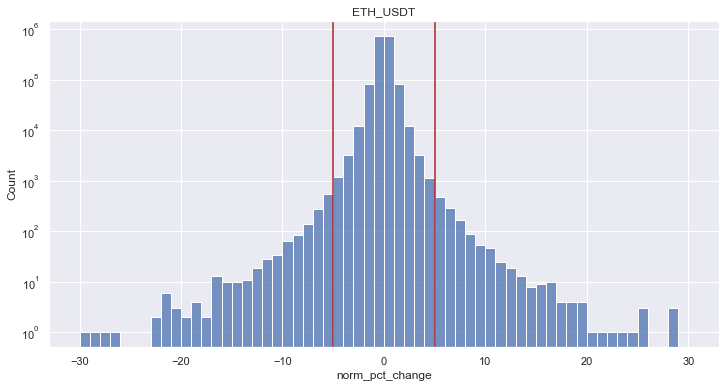

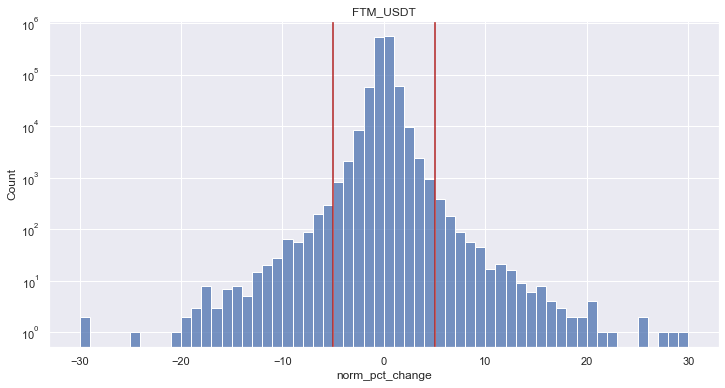

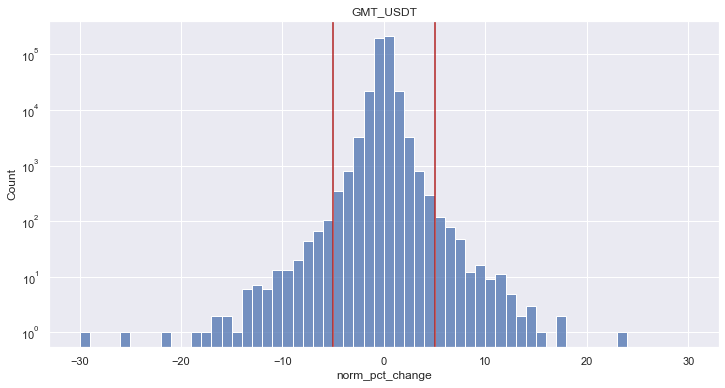

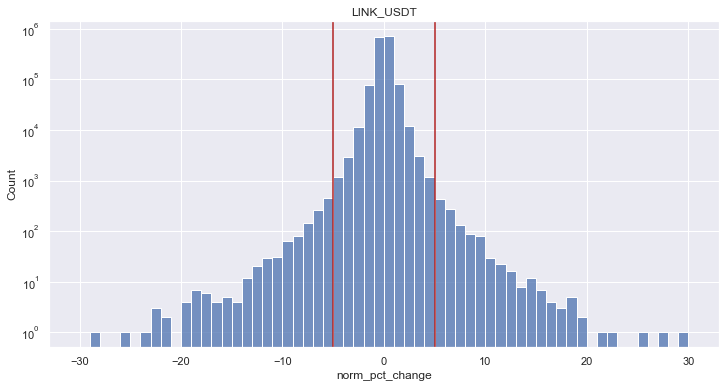

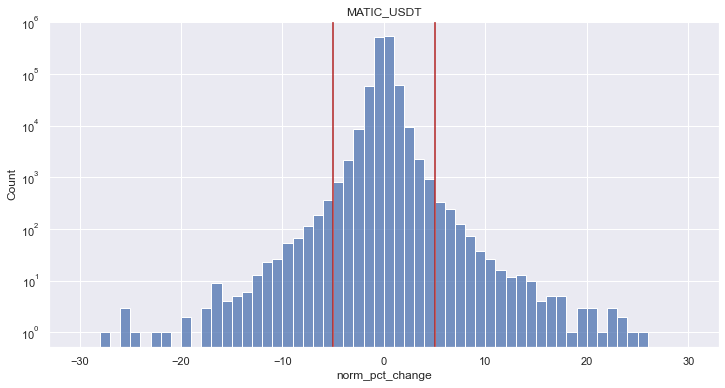

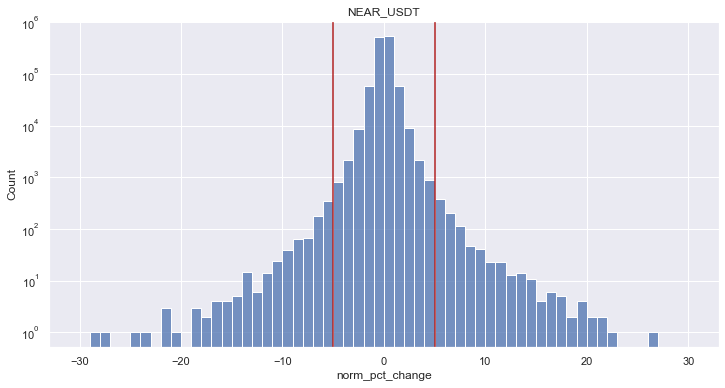

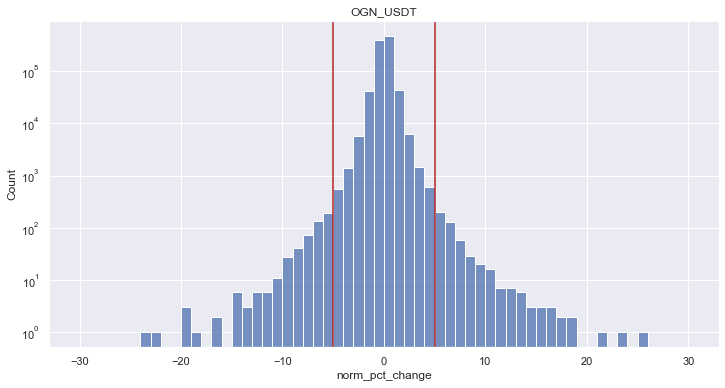

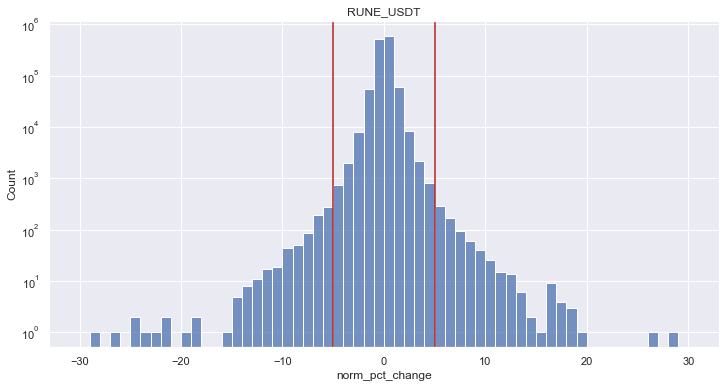

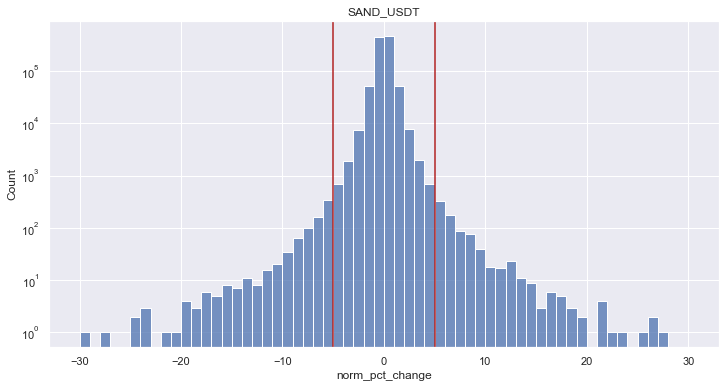

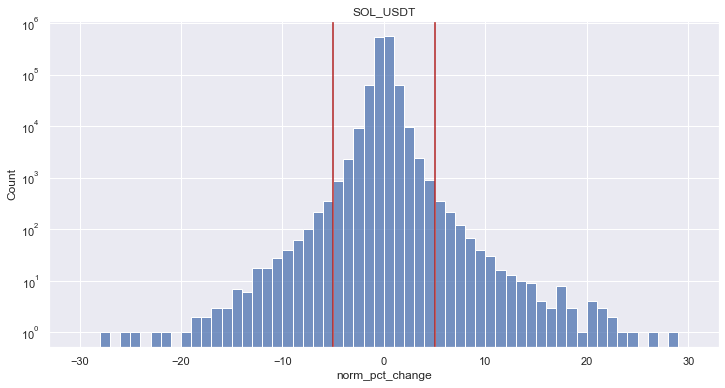

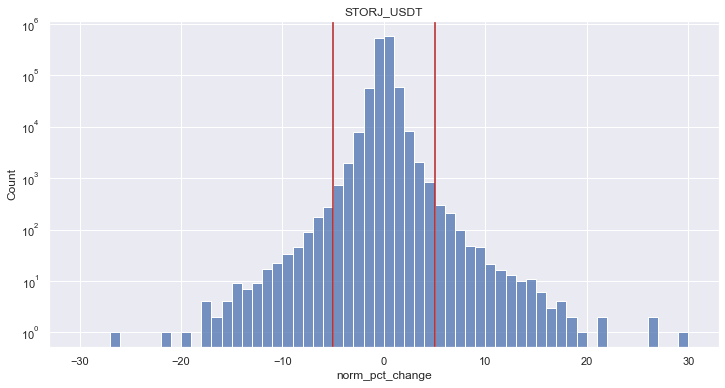

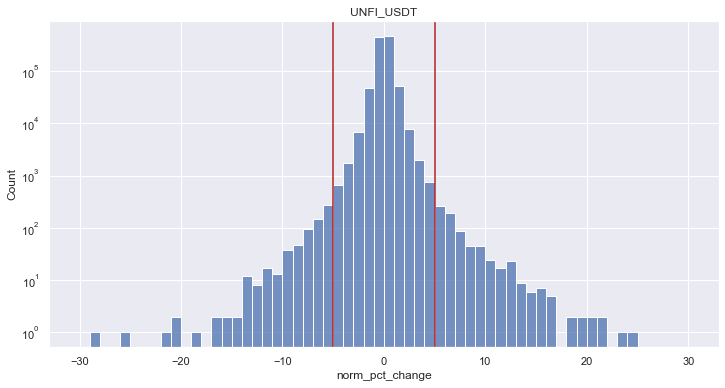

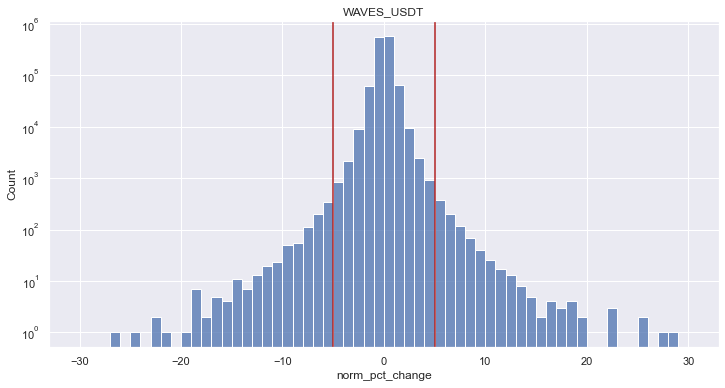

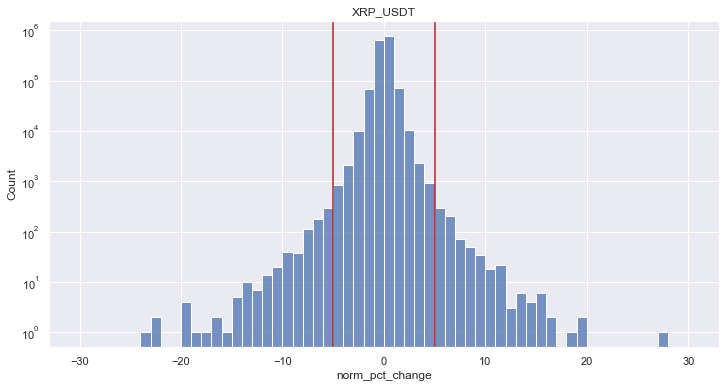

In [78]:
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 6)})

for currency_pair, frame in df.groupby(level='currency_pair'):
    sns.histplot(x=frame['norm_pct_change'], bins=range(-30, 31, 1)).set(title=currency_pair)
    plt.axvline(-SIGMA, color='firebrick')
    plt.axvline(SIGMA, color='firebrick')
    plt.yscale('log')
    plt.show()

The red lines indicate bounds for $5$ standard deviations from the mean price difference.

### Exporting Outlier Price Change Data

In [79]:
df = df.rename(columns={'norm_pct_change': 'normalized_ret', 'pct_change': 'ret'}, index={'currency_pair': 'asset'})
df = df[['normalized_ret', 'ret']]
df[abs(df['normalized_ret']) > SIGMA].head()

normalized_ret       ret
currency_pair timestamp                                          
APE_USDT      2022-03-17 20:42:00-04:00        5.386928  0.007771
              2022-03-18 19:46:00-04:00       -5.702976 -0.004003
              2022-03-18 20:58:00-04:00        8.573461  0.003971
              2022-03-19 17:31:00-04:00       18.685490  0.001214
              2022-03-19 17:32:00-04:00       15.444906  0.001061

In [80]:
df[abs(df['normalized_ret']) > SIGMA].to_csv('outlier_pct_changes.csv')